In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool

In [2]:
# load dataset
data=pd.read_csv('mbti_1.csv',index_col='type')
print(data.shape)
print(data[0:5])
#print(data.iloc[2])

(8675, 1)
                                                  posts
type                                                   
INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
ENTP  'I'm finding the lack of me in these posts ver...
INTP  'Good one  _____   https://www.youtube.com/wat...
INTJ  'Dear INTP,   I enjoyed our conversation the o...
ENTJ  'You're fired.|||That's another silly misconce...


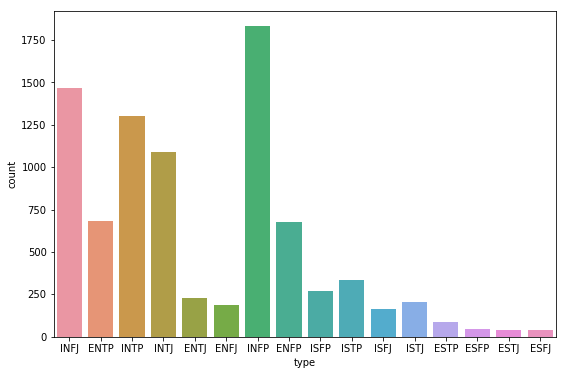

In [3]:
df = pd.read_csv('mbti_1.csv')
dims = (9, 6)
fig, axes = plt.subplots(figsize = dims)
sns.countplot(ax = axes, x = df['type'])
plt.show()

   type                                              posts  words_per_comment
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...              11.12
1  ENTP  'I'm finding the lack of me in these posts ver...              23.40
2  INTP  'Good one  _____   https://www.youtube.com/wat...              16.72
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...              21.28
4  ENTJ  'You're fired.|||That's another silly misconce...              19.34


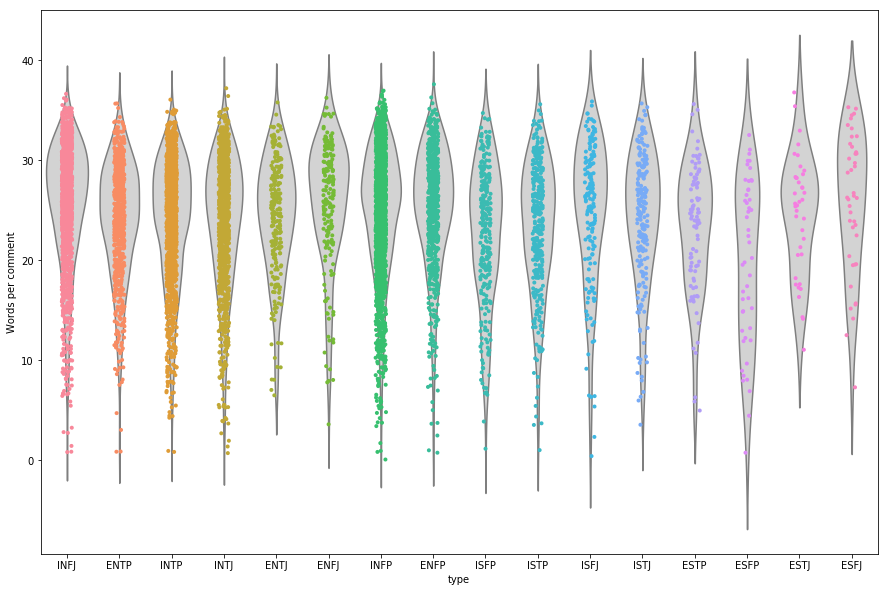

In [4]:
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
print(df.head())
plt.figure(figsize=(15,10))
sns.violinplot(x='type', y='words_per_comment', data=df, inner=None, color='lightgray')
sns.stripplot(x='type', y='words_per_comment', data=df, size=4, jitter=True)
plt.ylabel('Words per comment')
plt.show()

In [8]:
from sklearn.preprocessing import LabelBinarizer
text = data
# One hot encode labels
labels=text.index.tolist()
encoder=LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
labels=encoder.fit_transform(labels)
labels=np.array(labels)
print(labels[50:55])

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


In [9]:
mbti_dict={0:'ENFJ',1:'ENFP',2:'ENTJ',3:'ENTP',4:'ESFJ',5:'ESFP',6:'ESTJ',7:'ESTP',8:'INFJ',9:'INFP',10:'INTJ',11:'INTP',12:'ISFJ',13:'ISFP',14:'ISFP',15:'ISTP'}

In [10]:
import re

# Function to clean data ... will be useful later
def post_cleaner(post):
    """cleans individual posts`.
    Args:
        post-string
    Returns:
         cleaned up post`.
    """
    # Covert all uppercase characters to lower case
    post = post.lower() 
    
    # Remove |||
    post=post.replace('|||',"") 

    # Remove URLs, links etc
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 
    # This would have removed most of the links but probably not all 

    # Remove puntuations 
    puncs1=['@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']','|','\\','"',"'",';',':','<','>','/']
    for punc in puncs1:
        post=post.replace(punc,'') 

    puncs2=[',','.','?','!','\n']
    for punc in puncs2:
        post=post.replace(punc,' ') 
    # Remove extra white spaces
    post=re.sub( '\s+', ' ', post ).strip()
    return post

In [11]:
# Clean up posts
# Covert pandas dataframe object to list. I prefer using lists for prepocessing. 
posts=data.posts.tolist()
posts=[post_cleaner(post) for post in posts]

In [12]:
# Count total words
from collections import Counter

word_count=Counter()
for post in posts:
    word_count.update(post.split(" "))
print(len(word_count))
#print(word_count)

172862


In [13]:
# Size of the vocabulary available to the RNN
vocab_len=len(word_count)
print(vocab_len)

print(len(posts[0]))

172862
3094


In [14]:
# Create a look up table 
vocab = sorted(word_count, key=word_count.get, reverse=True)
# Create your dictionary that maps vocab words to integers here
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

posts_ints=[]
for post in posts:
    posts_ints.append([vocab_to_int[word] for word in post.split()])

print(posts_ints[0])
print(len(posts_ints[0]))

[5, 141, 1287, 61261, 22, 704, 1849, 2069, 61262, 89, 72, 2, 84, 13376, 286, 11, 39, 108, 24, 2180, 14, 84, 6, 375, 196, 2, 722, 286, 12336, 7, 2, 241, 115, 12, 133, 148, 574, 24, 134, 1034, 185, 5874, 2141, 2, 459, 189, 760, 11, 61263, 61264, 279, 3, 416, 6, 39, 7396, 34, 86, 814, 14, 4, 238, 3, 22, 20, 3969, 43, 2, 59, 11, 217, 475, 6, 1557, 154, 3, 523, 2, 205, 242, 26, 242, 6, 2556, 26, 61265, 61266, 308, 5, 274, 492, 712, 1216, 12646, 61267, 41, 257, 7320, 985, 6, 1077, 39, 3298, 5, 1, 31, 161, 1077, 64, 169, 1107, 11, 39, 130, 2800, 3857, 1988, 11, 7018, 150, 154, 28501, 26, 4, 5875, 2237, 510, 211, 62, 16, 565, 3458, 443, 2801, 8, 309, 95, 32, 6502, 218, 7, 81, 3, 33, 49, 47, 90, 408, 221, 627, 309, 218, 630, 342, 5, 4234, 40, 532, 73, 43, 76, 11, 7018, 5184, 9, 1027, 4, 464, 492, 5, 4, 75, 46, 41, 8, 939, 4, 75, 46, 41, 8, 9, 830, 1489, 11, 8, 1, 56, 22, 354, 10260, 2, 684, 6, 111, 627, 11279, 613, 194, 35, 104, 39, 417, 464, 567, 1120, 62, 5, 35, 21, 39, 92, 951, 417, 464, 567

In [15]:

posts_lens = Counter([len(x) for x in posts])
print("Zero-length reviews: {}".format(posts_lens[0]))
print("Maximum review length: {}".format(max(posts_lens)))
print("Minimum review length: {}".format(min(posts_lens)))

seq_len = 500
features=np.zeros((len(posts_ints),seq_len),dtype=int)
for i, row in enumerate(posts_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]
print(features[:10])

Zero-length reviews: 0
Maximum review length: 9588
Minimum review length: 13
[[   5  141 1287 ...  222  278    1]
 [  18  752    2 ...    2 1661 4184]
 [  75   46  386 ...   24 2233   75]
 ...
 [   1  259    3 ...   17  631    3]
 [  18   22  120 ... 4329  659   11]
 [  11   19 1199 ...   47 2500  112]]


In [16]:
# Split data into training, test and validation

split_frac = 0.8

num_ele=int(split_frac*len(features))
rem_ele=len(features)-num_ele
train_x, val_x = features[:num_ele],features[num_ele:int(rem_ele/2)+num_ele]
train_y, val_y = labels[:num_ele],labels[num_ele:int(rem_ele/2)+num_ele]

test_x =features[num_ele+int(rem_ele/2):]
test_y = labels[num_ele+int(rem_ele/2):]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(6940, 500) 
Validation set: 	(867, 500) 
Test set: 		(868, 500)


In [17]:
#hyperparameters
lstm_size = 256
lstm_layers = 1
batch_size = 256
learning_rate = 0.01
embed_dim=250

In [18]:
n_words = len(vocab_to_int) + 1 # Adding 1 because we use 0's for padding, dictionary started at 1

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    input_data = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [19]:
# Embedding
with graph.as_default():
    embedding= tf.Variable(tf.random_uniform(shape=(n_words,embed_dim),minval=-1,maxval=1))
    embed=tf.nn.embedding_lookup(embedding,input_data)
    print(embed.shape)

(?, ?, 250)


In [20]:
#LSTM cell
with graph.as_default():
    # basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop]* lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

In [21]:
#rnn forward pass
with graph.as_default():
    outputs,final_state=tf.nn.dynamic_rnn(cell,embed,dtype=tf.float32 )

In [22]:
with graph.as_default():
    
    pre = tf.layers.dense(outputs[:,-1], 16, activation=tf.nn.relu)
    predictions=tf.layers.dense(pre, 16, activation=tf.nn.softmax)
    
    cost = tf.losses.mean_squared_error(labels_, predictions)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [23]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [24]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [29]:
epochs = 3

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {input_data: x,
                    labels_: y,
                    keep_prob: 1.0,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {input_data: x,
                            labels_: y,
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/mbti.ckpt")


Epoch: 0/3 Iteration: 5 Train loss: 0.057
Epoch: 0/3 Iteration: 10 Train loss: 0.055
Epoch: 0/3 Iteration: 15 Train loss: 0.056
Epoch: 0/3 Iteration: 20 Train loss: 0.054
Epoch: 0/3 Iteration: 25 Train loss: 0.055
Val acc: 0.938
Epoch: 1/3 Iteration: 30 Train loss: 0.054
Epoch: 1/3 Iteration: 35 Train loss: 0.055
Epoch: 1/3 Iteration: 40 Train loss: 0.055
Epoch: 1/3 Iteration: 45 Train loss: 0.053
Epoch: 1/3 Iteration: 50 Train loss: 0.054
Val acc: 0.938
Epoch: 2/3 Iteration: 55 Train loss: 0.054
Epoch: 2/3 Iteration: 60 Train loss: 0.053
Epoch: 2/3 Iteration: 65 Train loss: 0.053
Epoch: 2/3 Iteration: 70 Train loss: 0.053
Epoch: 2/3 Iteration: 75 Train loss: 0.053
Val acc: 0.937
Epoch: 2/3 Iteration: 80 Train loss: 0.051


In [30]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {input_data: x,
                labels_: y,
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\mbti.ckpt
Test accuracy: 0.937
